<font size=8> DynapSE2 TimeConstant Extraction


In [1]:
#normal python import
from pickle import TRUE
import time
import sys
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt

sys.path.append(os.getcwd() + '/..')

#dynapse2 spikegen imports
from lib.dynapse2_util import *
from lib.dynapse2_network import Network
from lib.dynapse2_spikegen import send_events,get_fpga_time, send_virtual_events, poisson_gen, isi_gen,regular_gen
from lib.dynapse2_raster import *
from lib.dynapse2_obj import *

#Statistics imports
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy.signal import butter, filtfilt
from sklearn.linear_model import LinearRegression

#my imports
from configs.neuron_configs import neuron_configs
from adaptation import pc_single
from adaptation_lib.spike_stats import *
from adaptation_lib.dynapse_setup import *
from adaptation_lib.graphing import *
from adaptation_lib.tc_extraction import *


In [4]:
[board,profile_path,number_of_chips]=obtain_board()

<font size=8>GENERAL TEST SETUP


In [86]:

#Initialization
model = board.get_model()
model.reset(ResetType.PowerCycle, (1 << number_of_chips) - 1)
time.sleep(1)
myConfig = model.get_configuration()
model.apply_configuration(myConfig)
time.sleep(1)

#Set up network
network = Network(config=myConfig, profile_path=profile_path, num_chips=number_of_chips)
input_neuron_1 = network.add_virtual_group(size=1)#normal input
test_neurons_0 = network.add_group(chip=0, core=3 ,size=255)

#Input Connections
network.add_connection(source=input_neuron_1, target=test_neurons_0, probability=1,
                  dendrite=Dendrite.ampa, weight=[True, False, False, False],repeat=1)
network.connect()
#set up latches$
model.apply_configuration(myConfig)
time.sleep(1)

neuron_config=neuron_configs()
set_configs(myConfig,model,neuron_config) #all neuroons are set to their respetive empirically defined f-I curves
for c in range(4):
    set_parameter(myConfig.chips[0].cores[c].parameters,"SOIF_DC_P", 0, 0)
    set_parameter(myConfig.chips[0].cores[c].parameters,'DEAM_ETAU_P',1,60)
    set_parameter(myConfig.chips[0].cores[c].parameters,'DEAM_EGAIN_P',4,100) 
    set_parameter(myConfig.chips[0].cores[c].parameters, 'SYPD_EXT_N', 3, 200)

    set_parameter(myConfig.chips[0].cores[c].parameters, 'SYAM_W0_P', 3,100)#AMPA 
    set_parameter(myConfig.chips[0].cores[c].parameters, 'SYAM_W1_P', 3,100)#NMDA
    set_parameter(myConfig.chips[0].cores[c].parameters, 'SYAM_W2_P', 3,100)#GABA_B Substract
    set_parameter(myConfig.chips[0].cores[c].parameters, 'SYAM_W3_P', 3,100)#GABA_A Shunt 
model.apply_configuration(myConfig)
time.sleep(0.1)

#set neuron to monitor
myConfig.chips[0].cores[0].neuron_monitoring_on = True
myConfig.chips[0].cores[0].monitored_neuron =  40
model.apply_configuration(myConfig)
time.sleep(0.1)

<font size=8> No Adaptation First

In [177]:

for h in range(number_of_chips):
    for c in [0,1,2]:
        for n in range(256):
            myConfig.chips[h].cores[c].neurons[n].latch_so_adaptation = False
model.apply_configuration(myConfig)
time.sleep(1)


In [178]:

pulse_duration=300000
rest=100000
events=poisson_gen(0,pulse_duration,[input_neuron_1],[70])
events=events+poisson_gen(pulse_duration+rest,pulse_duration,[input_neuron_1],[100])
events=events+poisson_gen(2*pulse_duration+2*rest,pulse_duration,[input_neuron_1],[200])
events=events+poisson_gen(3*pulse_duration+3*rest,pulse_duration,[input_neuron_1],[100])
events=events+poisson_gen(4*pulse_duration+4*rest,pulse_duration,[input_neuron_1],[200])




In [181]:
data_path='/home/hector/Documents/dynapse-se2-data/general_tests/'
output_events=run_dynapse(neuron_config,board,events)
np.save(data_path+'SFA_Control.npy',output_events)


initilize run dynapse
initilize run dynapse

getting fpga time


setting virtual neurons



In [175]:
drain_neurons(myConfig,model)
undrain_neurons(myConfig,model,neuron_config)

/tmp/ipykernel_59093/1277166642.py:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


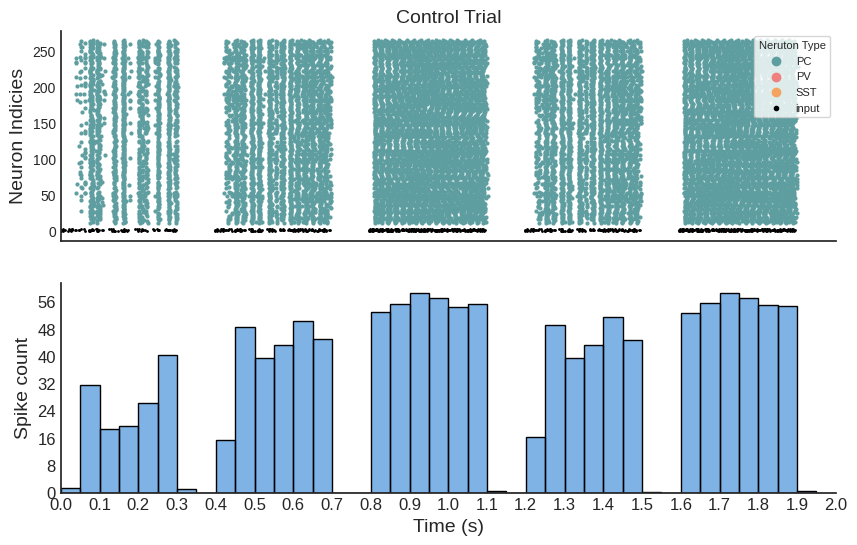

In [248]:
nvn=8
pvn=0
pcn=256
sstn=200
bin_size=0.050
duration=2
data_path='/home/hector/Documents/dynapse-se2-data/general_tests/'

output_events=np.load(data_path+'SFA_Control.npy',allow_pickle=True)
plt.style.use('seaborn-white')

output_events=np.asanyarray(output_events)
times=output_events[1]-output_events[1][0]
spike_id=output_events[0]
pc_id, pc_times = get_id_times(nvn, pcn, spike_id, times)
pv_id, pv_times = get_id_times(nvn + 1 + pcn, pvn, spike_id, times)
sst_id, sst_times = get_id_times(nvn + 2 + pcn + pvn, sstn, spike_id, times)

if nvn > 0:
    input_id = spike_id[spike_id <= nvn]
    input_time = times[spike_id <= nvn]

fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

ax1 = axs[0]
ax2 = axs[1]

# Raster plot
ax1.scatter(pc_times,pc_id,c='cadetblue',s=4,label='PC')
ax1.scatter(pv_times,pv_id,c='lightcoral',s=4,label='PV')
ax1.scatter(sst_times,sst_id,c='sandybrown',s=4,label='SST')
ax1.scatter(input_time,input_id,c='k',s=1,label='input')

ax1.set_ylabel('Neuron Indicies',fontsize=14)
ax1.legend(loc="upper right", title='Neruton Type', numpoints=1, fontsize=8, markerscale=3, title_fontsize=8, frameon=True)

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlim(0,duration)
ax1.set_title('Control Trial',fontsize=14)


# PSTH plot
spike_times = spike_time_arrays(output_events, nvn, pvn, pcn, sstn)[2]
psth, bins = psth_calc(spike_times, bin_size, duration)

if pcn>0:
    bar_color = (0, 0.4, 0.8, 0.5)
elif pvn>0:
    bar_color = (1.00, 0.50196, 0.50196,.5)
elif sstn>0:
    bar_color = (1.00000, 0.65098, 0.30196,.5)
else:
    bar_color = (0.70196, 0.70196, 0.80000,.5)

ax2.bar(bins[:-1], psth, width=bin_size, align='edge', color=bar_color, edgecolor='black', linewidth=1)

ax2.set_xlabel('Time (s)', fontsize=14)
ax2.set_ylabel('Spike count', fontsize=14)

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax2.set_xticks(np.arange(0,duration, 0.1))
ax2.xaxis.set_major_locator(ticker.MultipleLocator(.1))
ax2.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax2.tick_params(axis='both', which='major', labelsize=12)



In [183]:
def compute_isi(spike_times_all, spike_id, indices_range):
    ff_list = []
    time_list = []
    for i in indices_range:
        occurences = spike_times_all[spike_id == i]
        if len(occurences) > 0:
            isi = np.diff(occurences)
            if len(isi) > 0 and not (isi == 0).any():
                ff_list.append(1 / isi)
                time_list.append(occurences[:-1])
    return ff_list, time_list

def frequency_arrays(output_events, nvn, pcn, pvn, sstn):
    output_events = np.asanyarray(output_events)
    spike_times_all = output_events[1] - output_events[1][0]
    spike_id = output_events[0]
    neuron_data = {}

    if pcn > 0:
        neuron_data["PC"] = compute_isi(spike_times_all, spike_id, range(nvn + 1, pcn + 1 + nvn))
    if pvn > 0:
        neuron_data["PV"] = compute_isi(spike_times_all, spike_id, range(nvn + pcn + 1, nvn + pcn + pvn + 1))
    if sstn > 0:
        neuron_data["SST"] = compute_isi(spike_times_all, spike_id, range(nvn + pcn + pvn + 1, nvn + pcn + pvn + sstn + 1))
    
    return neuron_data

# ... (put your previous code here)

neuron_data = frequency_arrays(output_events, nvn, pcn, pvn, sstn)

<font size=8> Now Adaptation

In [251]:

for h in range(number_of_chips):
    for c in [0,1,2]:
        for n in range(256):
            myConfig.chips[h].cores[c].neurons[n].latch_so_adaptation = True
model.apply_configuration(myConfig)
time.sleep(1)


In [255]:

for c in range(4):
   set_parameter(myConfig.chips[0].cores[c].parameters, 'SOAD_PWTAU_N',2,200)
   set_parameter(myConfig.chips[0].cores[c].parameters, 'SOAD_GAIN_P', 3,200)
   set_parameter(myConfig.chips[0].cores[c].parameters, 'SOAD_TAU_P', 0,100)
   set_parameter(myConfig.chips[0].cores[c].parameters, 'SOAD_W_N', 3,200)
   set_parameter(myConfig.chips[0].cores[c].parameters, 'SOAD_CASC_P', 5,250)
model.apply_configuration(myConfig)
time.sleep(0.1)

In [256]:
data_path='/home/hector/Documents/dynapse-se2-data/general_tests/'
output_events=run_dynapse(neuron_config,board,events)
np.save(data_path+'SFA_Trial.npy',output_events)


initilize run dynapse
initilize run dynapse

getting fpga time


setting virtual neurons



<font size=8>


/tmp/ipykernel_59093/3229792709.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


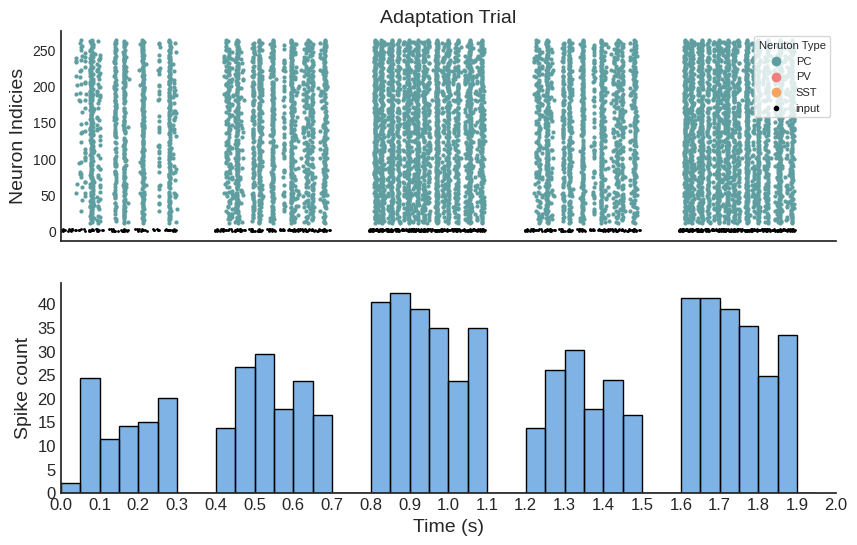

In [257]:
nvn=7
pvn=200
pcn=256
sstn=200
bin_size=0.050
duration=2

plt.style.use('seaborn-white')

output_events=np.load(data_path+'SFA_Trial.npy',allow_pickle=True)


output_events=np.asanyarray(output_events)
times=output_events[1]-output_events[1][0]
spike_id=output_events[0]
pc_id, pc_times = get_id_times(nvn, pcn, spike_id, times)
pv_id, pv_times = get_id_times(nvn + 1 + pcn, pvn, spike_id, times)
sst_id, sst_times = get_id_times(nvn + 2 + pcn + pvn, sstn, spike_id, times)

if nvn > 0:
    input_id = spike_id[spike_id <= nvn]
    input_time = times[spike_id <= nvn]

fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10, 6), sharex=True)

# Raster plot
ax1.scatter(pc_times,pc_id,c='cadetblue',s=4,label='PC')
ax1.scatter(pv_times,pv_id,c='lightcoral',s=4,label='PV')
ax1.scatter(sst_times,sst_id,c='sandybrown',s=4,label='SST')
ax1.scatter(input_time,input_id,c='k',s=1,label='input')

ax1.set_ylabel('Neuron Indicies',fontsize=14)
ax1.legend(loc="upper right", title='Neruton Type', numpoints=1, fontsize=8, markerscale=3, title_fontsize=8, frameon=True)

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlim(0,duration)
ax1.set_title('Adaptation Trial',fontsize=14)
# PSTH plot
spike_times = spike_time_arrays(output_events, nvn, pvn, pcn, sstn)[2]
psth, bins = psth_calc(spike_times, bin_size, duration)

if pcn>0:
    bar_color = (0, 0.4, 0.8, 0.5)
elif pvn>0:
    bar_color = (1.00, 0.50196, 0.50196,.5)
elif sstn>0:
    bar_color = (1.00000, 0.65098, 0.30196,.5)
else:
    bar_color = (0.70196, 0.70196, 0.80000,.5)

ax2.bar(bins[:-1], psth, width=bin_size, align='edge', color=bar_color, edgecolor='black', linewidth=1)

ax2.set_xlabel('Time (s)', fontsize=14)
ax2.set_ylabel('Spike count', fontsize=14)

ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax2.set_xticks(np.arange(0,duration, 0.1))
ax2.xaxis.set_major_locator(ticker.MultipleLocator(.1))
ax2.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
ax2.tick_params(axis='both', which='major', labelsize=12)

plt.show()

<font size=8> Attempt to record and go,this dosent work for some reason

In [9]:
neuron_config['input_type']='Poisson 2'

def measure_dynapse_run(neuron_config, board,events, frequency, duration):
    # Define constants
    CHANNEL = 0  # Use first channel
    FREQUENCY = frequency  # Sampling frequency
    DURATION = duration  # Duration of recording in seconds
    BUFFER_SIZE = int(FREQUENCY * DURATION)  # Number of samples
    time_values = None
    samples = None
    result = {}
    try:
        # Create a DWF instance
        analog_instrument = dwf.DwfAnalogIn()
        # Open the first available device
        analog_instrument.channelEnableSet(CHANNEL, True)
        analog_instrument.channelRangeSet(CHANNEL, 1.0)  # Set voltage range to -5V to +5V
        # Set the sample rate and buffer size
        analog_instrument.frequencySet(FREQUENCY)
        analog_instrument.recordLengthSet(DURATION)
        # Wait for the device to settle
        time.sleep(.5)
        # Start the acquisition
        analog_instrument.configure(False, True)
        time.sleep(.02)
        # Start another function in a separate thread
        threading.Thread(target=run_dynapse_thread, args=(neuron_config, board, events, result)).start()
        # Wait until the acquisition is done
        while True:
            if analog_instrument.status(True) == dwf.DwfStateDone:
                break
        # Get the acquired samples
        samples = analog_instrument.statusData(CHANNEL, BUFFER_SIZE)
        samples=np.array(samples)*1000
        # Generate corresponding time values
        time_values = np.linspace(0, DURATION, num=BUFFER_SIZE, endpoint=False)
    finally:
        # Always close the device
        analog_instrument.close()
    return time_values, samples, result.get('output', None)

[time_values_1,voltages_1,output_events]=measure_dynapse_run(neuron_config,board,events,frequency=1000,duration=5)
print(output_events)

initilize run dynapse
initilize run dynapse

getting fpga time



KeyboardInterrupt: 


setting virtual neurons



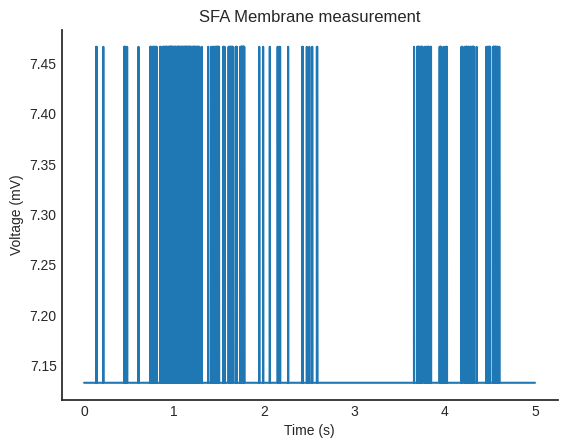

In [12]:
fig,ax=plt.subplots()
ax.plot(time_values_1, voltages_1)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Voltage (mV)')
ax.set_title('SFA Membrane measurement')#set DC on neurons

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

In [13]:
def get_id_times(nvn, pcn, test_id, time):
    id = []
    times = []
    if pcn > 0:
        condition = (test_id > nvn + 1) & (test_id < nvn + 1 + pcn)
        id = test_id[condition]
        times = time[condition]
    return id, times


In [14]:
nvn=4
pvn=200
pcn=256
sstn=200
plt.style.use('seaborn-white')
output_events=np.asanyarray(output_events)
times=output_events[1]-output_events[1][0]
spike_id=output_events[0]
pc_id, pc_times = get_id_times(nvn, pcn, spike_id, times)
pv_id, pv_times = get_id_times(nvn + 1 + pcn, pvn, spike_id, times)
sst_id, sst_times = get_id_times(nvn + 2 + pcn + pvn, sstn, spike_id, times)
if nvn > 0:
    input_id = spike_id[spike_id <= nvn]
    input_time = times[spike_id <= nvn]

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(pc_times,pc_id,c='cadetblue',s=4,label='PC')
ax.scatter(pv_times,pv_id,c='lightcoral',s=4,label='PV')
ax.scatter(sst_times,sst_id,c='sandybrown',s=4,label='SST')
ax.scatter(input_time,input_id,c='k',s=1,label='input')
ax.set_xlabel('Time (s)',fontsize=18)
ax.set_ylabel('Neuron Indicies',fontsize=18)
ax.legend(loc="upper right", title='Neruton Type', numpoints=1, fontsize=8, markerscale=3, title_fontsize=8, frameon=True)
#set Time stamp
#set input strenght annotation
#set CV and Synaptic strength annotation
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

/tmp/ipykernel_18182/1795837453.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

In [22]:
def frequency_arrays(output_events):
    output_events=np.asanyarray(output_events)
    spike_times_all=output_events[1]-output_events[1][0]
    spike_id=output_events[0]
    pc_ff_list=[]
    pc_time_list=[]
    pvn_ff_list=[]
    pvn_time_list=[]
    sstn_ff_list=[]
    sstn_time_list=[]
    nvn=4
    pcn=255
    pvn=0
    sstn=0
    if pcn>0:
        for i in range(nvn+1,pcn+1+nvn):  
                    occurences=spike_times_all[spike_id==i]
                    ocurrence_times=spike_times_all[spike_id==i]
                    if len(occurences)>0:
                        isi=np.diff(occurences)
                        if(isi==0).any():
                            print("removed")
                        else:
                            #numpy append to isi to ff list
                            pc_ff_list.append(1/isi)
                            pc_time_list.append(ocurrence_times)
    if pvn>0:
        for i in range(nvn+pcn+1,nvn+pcn+pvn+1):
                    occurences=spike_times_all[spike_id==i]
                    ocurrence_times=spike_times_all[spike_id==i]
                    if len(occurences)>0:
                        isi=np.diff(occurences)
                        if(isi==0).any():
                            print("removed")
                        else:
                            #numpy append to isi to ff list
                            pvn_ff_list.append(1/isi)
                            pvn_time_list.append(ocurrence_times)
    if sstn>0:
        for i in range(nvn+pcn+pvn+1,nvn+pcn+pvn+sstn+1):
                    occurences=spike_times_all[spike_id==i]
                    ocurrenc# Frequency over time plot for PC neurons
if "PC" in neuron_data:
    pc_ff_list, pc_time_list = neuron_data["PC"]
    ax3 = axs[2]
    # Flattening the lists and plotting
    ax3.scatter(np.concatenate(pc_time_list), np.concatenate(pc_ff_list), s=1)
    ax3.set_ylabel('PC Frequency (Hz)', fontsize=14)
    ax3.spines['right'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.set_ylim(bottom=0)

# Frequency over time plot for PV neurons
if "PV" in neuron_data:
    pvn_ff_list, pvn_time_list = neuron_data["PV"]
    ax4 = axs[3]
    # Flattening the lists and plotting
    ax4.scatter(np.concatenate(pvn_time_list), np.concatenate(pvn_ff_list), s=1)
    ax4.set_xlabel('Time (s)', fontsize=14)
    ax4.set_ylabel('PV Frequency (Hz)', fontsize=14)
    ax4.spines['right'].set_visible(False)
    ax4.spines['top'].set_visible(False)
    ax4.set_ylim(bottom=0)
plt.show()e_times=spike_times_all[spike_id==i]
                    if len(occurences)>0:
                        isi=np.diff(occurences)
                        if(isi==0).any():
                            print("removed")
                        else:
                            #numpy append to isi to ff list
                            sstn_ff_list.append(1/isi)
                            sstn_time_list.append(ocurrence_times)
    return pc_ff_list, pc_time_list, pvn_ff_list, pvn_time_list, sstn_ff_list, sstn_time_list
[pc_ff_list, pc_time_list, pvn_ff_list, pvn_time_list, sstn_ff_list, sstn_time_list]=frequency_arrays(output_events)

In [3]:
def compute_isi(spike_times_all, spike_id, indices_range):
    ff_list = []
    time_list = []
    for i in indices_range:
        occurences = spike_times_all[spike_id == i]
        if len(occurences) > 0:
            isi = np.diff(occurences)
            if len(isi) > 0 and not (isi == 0).any():
                ff_list.append(1 / isi)
                time_list.append(occurences[:-1])
    return ff_list, time_list

def frequency_arrays(output_events, nvn, pcn, pvn, sstn):
    output_events = np.asanyarray(output_events)
    spike_times_all = output_events[1] - output_events[1][0]
    spike_id = output_events[0]
    neuron_data = {}

    if pcn > 0:
        neuron_data["PC"] = compute_isi(spike_times_all, spike_id, range(nvn + 1, pcn + 1 + nvn))
    if pvn > 0:
        neuron_data["PV"] = compute_isi(spike_times_all, spike_id, range(nvn + pcn + 1, nvn + pcn + pvn + 1))
    if sstn > 0:
        neuron_data["SST"] = compute_isi(spike_times_all, spike_id, range(nvn + pcn + pvn + 1, nvn + pcn + pvn + sstn + 1))
    
    return neuron_data

# ... (put your previous code here)

neuron_data = frequency_arrays(output_events, nvn, pcn, pvn, sstn)

NameError: name 'output_events' is not defined

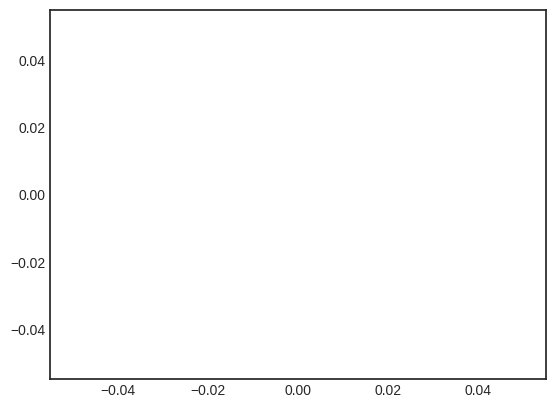

In [23]:
i=30
plt.plot(pc_time_list[i][:-1],pc_ff_list[i])

In [ ]:
# Frequency over time plot for PC neurons
if "PC" in neuron_data:
    pc_ff_list, pc_time_list = neuron_data["PC"]
    ax3 = axs[2]
    # Flattening the lists and plotting
    ax3.scatter(np.concatenate(pc_time_list), np.concatenate(pc_ff_list), s=1)
    ax3.set_ylabel('PC Frequency (Hz)', fontsize=14)
    ax3.spines['right'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.set_ylim(bottom=0)

# Frequency over time plot for PV neurons
if "PV" in neuron_data:
    pvn_ff_list, pvn_time_list = neuron_data["PV"]
    ax4 = axs[3]
    # Flattening the lists and plotting
    ax4.scatter(np.concatenate(pvn_time_list), np.concatenate(pvn_ff_list), s=1)
    ax4.set_xlabel('Time (s)', fontsize=14)
    ax4.set_ylabel('PV Frequency (Hz)', fontsize=14)
    ax4.spines['right'].set_visible(False)
    ax4.spines['top'].set_visible(False)
    ax4.set_ylim(bottom=0)
plt.show()